# CRISP-DM


# 1. Compréhension du métier

L’objectif principal est de prédire le prix des actions de Tesla à partir de données boursières historiques. Cette prédiction peut aider les investisseurs à prendre de meilleures décisions d’achat ou de vente.
Les parties prenantes attendent des modèles précis et exploitables, capables d'anticiper les tendances du marché dans un environnement financier volatil.













# 2. Compréhension des données

Les données proviennent de Yahoo Finance, incluant les prix de clôture de Tesla (TSLA_Close) et d'autres grandes entreprises technologiques comme AMZN_Close, GOOGL_Close, NVDA_Close, etc.
Les premières analyses exploratoires ont permis d'identifier les variables fortement corrélées avec Tesla, utiles comme exogènes dans les modèles (ex. : AMZN, GOOGL, NVDA).



# 3. Préparation des données

- Traitement des valeurs manquantes

- Normalisation et découpage temporel des séries

- Transformation des données pour les adapter aux modèles de séries temporelles

- Création de variables exogènes (données auxiliaires liées à d'autres actions)

# 4. Modélisation

4 types de modèles ont été expérimentés :

- ARIMA,SARIMA :

- SARIMAX : Modèle classique de séries temporelles avec données exogènes. Il donne de bons résultats sur les tendances générales.

- Prophet : Modèle de Facebook performant pour détecter les tendances et saisonnalités. Il a donné les meilleurs scores de précision.

- LSTM (Long Short-Term Memory) : Réseau de neurones récurrent, utile pour capturer les dépendances temporelles non linéaires. Le modèle LSTM n’a pas été concluant dans cette version à cause d’un faible score R².

# 5. Évaluation

Les modèles ont été comparés à l’aide de plusieurs métriques :

MAE, RMSE, MAPE : pour évaluer l'erreur de prédiction.

R² : pour mesurer la proportion de variance expliquée.

# 6. Déploiement / Plan d’action

Le modèle Prophet peut être intégré à une interface de visualisation ou à une application pour :

Suivre l'évolution prédite des actions Tesla

Aider les utilisateurs à anticiper les fluctuations boursières

Une documentation des résultats, visualisations et métriques est prévue dans une présentation PowerPoint pour les parties prenantes.

In [ ]:
#!pip install yfinance
#!pip install pmdarima
#!pip install tensorflow
#!pip install pmdarima
#!pip install streamlit
#!pip install --upgrade --force-reinstall pmdarima


In [ ]:
# Gestion des données
import pandas as pd
import numpy as np

#  Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

#  Prétraitement des données
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#  Analyse de séries temporelles & statistiques
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import shapiro
from scipy.spatial.distance import cdist

#  Modèles de clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#  Modélisation avancée
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from prophet import Prophet

# Évaluation des modèles
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#  Chargement des données financières
import yfinance as yf


- TSLA_Close : Tesla, Inc. (Tesla)

- META_Close : Meta Platforms, Inc. (anciennement Facebook)

- GOOGL_Close : Alphabet Inc. (la société mère de Google)

- BABA_Close : Alibaba Group Holding Limited (Alibaba)

- AMZN_Close : Amazon.com, Inc. (Amazon)

- F_Close : Ford Motor Company (Ford)

- NVDA_Close : NVIDIA Corporation (NVIDIA)

- ORCL_Close : Oracle Corporation (Oracle)

- GM_Close : General Motors Company (GM)

- TM_Close : Toyota Motor Corporation (Toyota)

- HMC_Close : Honda Motor Co., Ltd. (Honda)

In [ ]:

# Définir les tickers des actions
stocks = ["TSLA", "META", "GOOGL", "BABA", "AMZN", "F", "NVDA", "ORCL", "GM","TM", "HMC" ]

# Définir la période
start_date = "2015-01-01"
end_date = "2025-03-13"

# Récupérer les données historiques sur la période définie
data_frames = []
for ticker in stocks:
    df = yf.Ticker(ticker).history(start=start_date, end=end_date)
    df = df[["Close"]]
    df.columns = [f"{ticker}_{col}" for col in df.columns]
    data_frames.append(df)

# Concaténer toutes les données dans un seul DataFrame
data = pd.concat(data_frames, axis=1)


# PARTIE A : ANALYSE ET PRÉTRAITEMENT

## 1. Exploration et reporting

In [ ]:
# L'objectif est d'obtenir une première compréhension des données et de repérer d'éventuelles anomalies.

In [ ]:
# Vérifier les 5 premières lignes du dataset
data.head(5)

,TSLA_Close,META_Close,GOOGL_Close,BABA_Close,AMZN_Close,F_Close,NVDA_Close,ORCL_Close,GM_Close,TM_Close,HMC_Close
Date,,,,,,,,,,,
2015-01-02 00:00:00-05:00,14.620667,78.082001,26.351515,100.051353,15.4260,8.870362,0.483099,37.728313,27.108501,118.139420,23.737602
2015-01-05 00:00:00-05:00,14.006000,76.827919,25.849415,97.540405,15.1095,8.523865,0.474940,37.199226,26.711674,115.977249,23.248247
2015-01-06 00:00:00-05:00,14.085333,75.792793,25.211466,99.780937,14.7645,8.443014,0.460540,36.815193,27.116280,114.783340,23.119898
2015-01-07 00:00:00-05:00,14.063333,75.792793,25.137321,98.631699,14.9210,8.685564,0.459340,36.823723,27.886589,117.669388,23.352541
2015-01-08 00:00:00-05:00,14.041333,77.813263,25.224903,101.432373,15.0230,8.905013,0.476619,37.045601,28.166693,119.934967,23.649357


In [ ]:
# Afficher la liste des variables
data.columns.tolist()

['TSLA_Close',
 'META_Close',
 'GOOGL_Close',
 'BABA_Close',
 'AMZN_Close',
 'F_Close',
 'NVDA_Close',
 'ORCL_Close',
 'GM_Close',
 'TM_Close',
 'HMC_Close']

In [ ]:
# Afficher le nbre d'observations et variables du dataset
data.shape

(2563, 11)

In [ ]:
# Afficher des informations générales sur le dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2563 entries, 2015-01-02 00:00:00-05:00 to 2025-03-12 00:00:00-04:00
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   TSLA_Close   2563 non-null   float64
 1   META_Close   2563 non-null   float64
 2   GOOGL_Close  2563 non-null   float64
 3   BABA_Close   2563 non-null   float64
 4   AMZN_Close   2563 non-null   float64
 5   F_Close      2563 non-null   float64
 6   NVDA_Close   2563 non-null   float64
 7   ORCL_Close   2563 non-null   float64
 8   GM_Close     2563 non-null   float64
 9   TM_Close     2563 non-null   float64
 10  HMC_Close    2563 non-null   float64
dtypes: float64(11)
memory usage: 240.3 KB


In [ ]:
# Résumé statistique des données
data.describe(include = "number")

,TSLA_Close,META_Close,GOOGL_Close,BABA_Close,AMZN_Close,F_Close,NVDA_Close,ORCL_Close,GM_Close,TM_Close,HMC_Close
count,2563.000000,2563.000000,2563.000000,2563.000000,2563.000000,2563.000000,2563.000000,2563.000000,2563.000000,2563.000000,2563.000000
mean,120.068665,229.307530,84.246357,131.716132,103.457297,8.955682,22.784298,66.344882,36.003759,143.397063,26.062270
std,117.897874,133.889365,45.389235,57.039553,56.114817,2.379001,35.223892,36.174310,9.340436,30.923004,3.482648
min,9.578000,73.702644,24.734745,55.424198,14.347500,3.164624,0.459340,29.410698,16.335400,96.798271,17.586300
25%,17.332999,136.969460,47.477512,82.274998,48.810001,7.361932,3.584591,40.481388,29.183729,120.704975,23.494050
50%,34.933334,183.624573,66.359741,108.250534,95.143997,8.515285,6.612067,50.349648,34.101421,134.029999,25.430357
75%,224.040001,289.216919,121.753147,173.839218,155.569000,10.470631,22.266551,83.787060,39.664047,165.575005,28.072147
max,479.859985,736.015198,206.142593,306.276886,242.059998,19.979618,149.416245,191.271088,63.921967,254.770004,37.680000


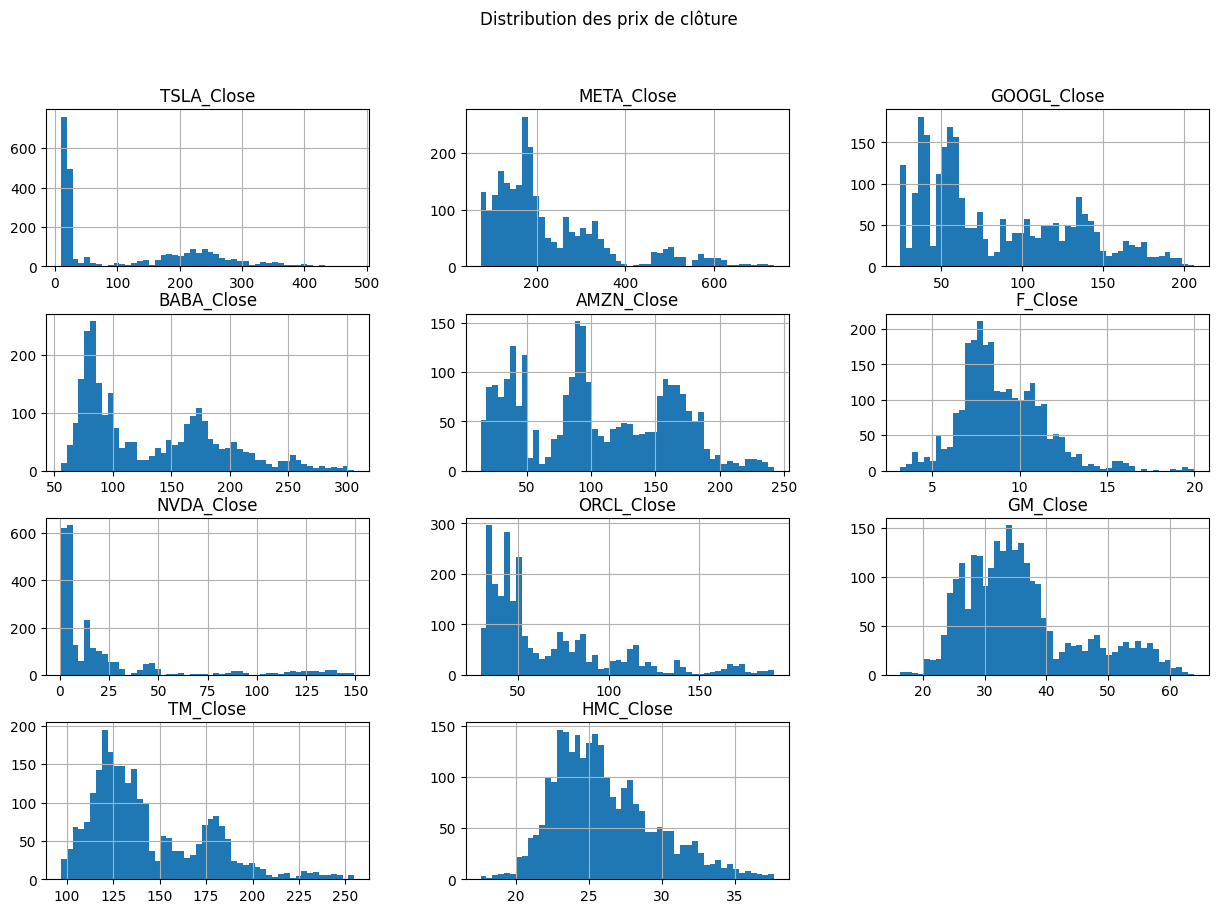

In [ ]:
# Tracer les distributions des prix de clôture des actions
data.hist(figsize=(15, 10), bins=50)
plt.suptitle("Distribution des prix de clôture")
plt.show()

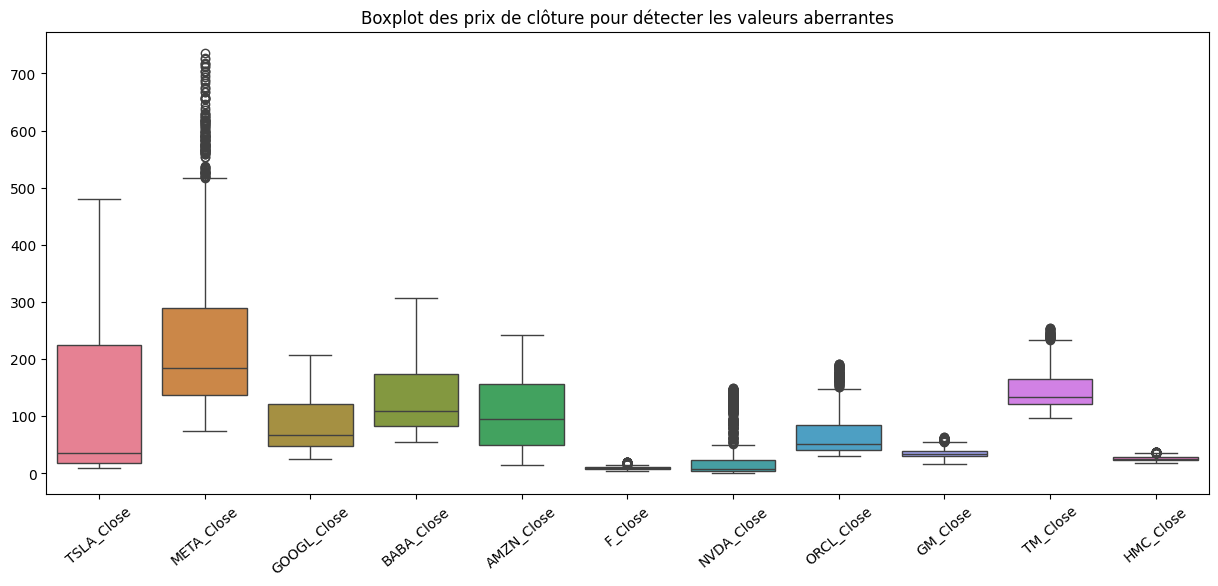

In [ ]:
# Tracer des boxplots pour détecter des valeurs aberrantes
plt.figure(figsize=(15, 6))
sns.boxplot(data=data)
plt.xticks(rotation=40)
plt.title("Boxplot des prix de clôture pour détecter les valeurs aberrantes")
plt.show()

## 2️- Prétraitement des données

#### Valeurs manquantes

In [ ]:
# Somme des valeurs manquantes
valeur_manq = data.isnull().sum()

# Pourcentage des valeurs manquantes
pourc_valeur_manq = (valeur_manq / len(data)) * 100

# Tableau des valeurs manquantes par variables
table_valeur_manq = pd.DataFrame({ "Valeur_manquante": valeur_manq, "Porcentage": pourc_valeur_manq})
print(table_valeur_manq)

             Valeur_manquante  Porcentage
TSLA_Close                  0         0.0
META_Close                  0         0.0
GOOGL_Close                 0         0.0
BABA_Close                  0         0.0
AMZN_Close                  0         0.0
F_Close                     0         0.0
NVDA_Close                  0         0.0
ORCL_Close                  0         0.0
GM_Close                    0         0.0
TM_Close                    0         0.0
HMC_Close                   0         0.0


Notre jeu de donnée ne présente aucune valeur manquante

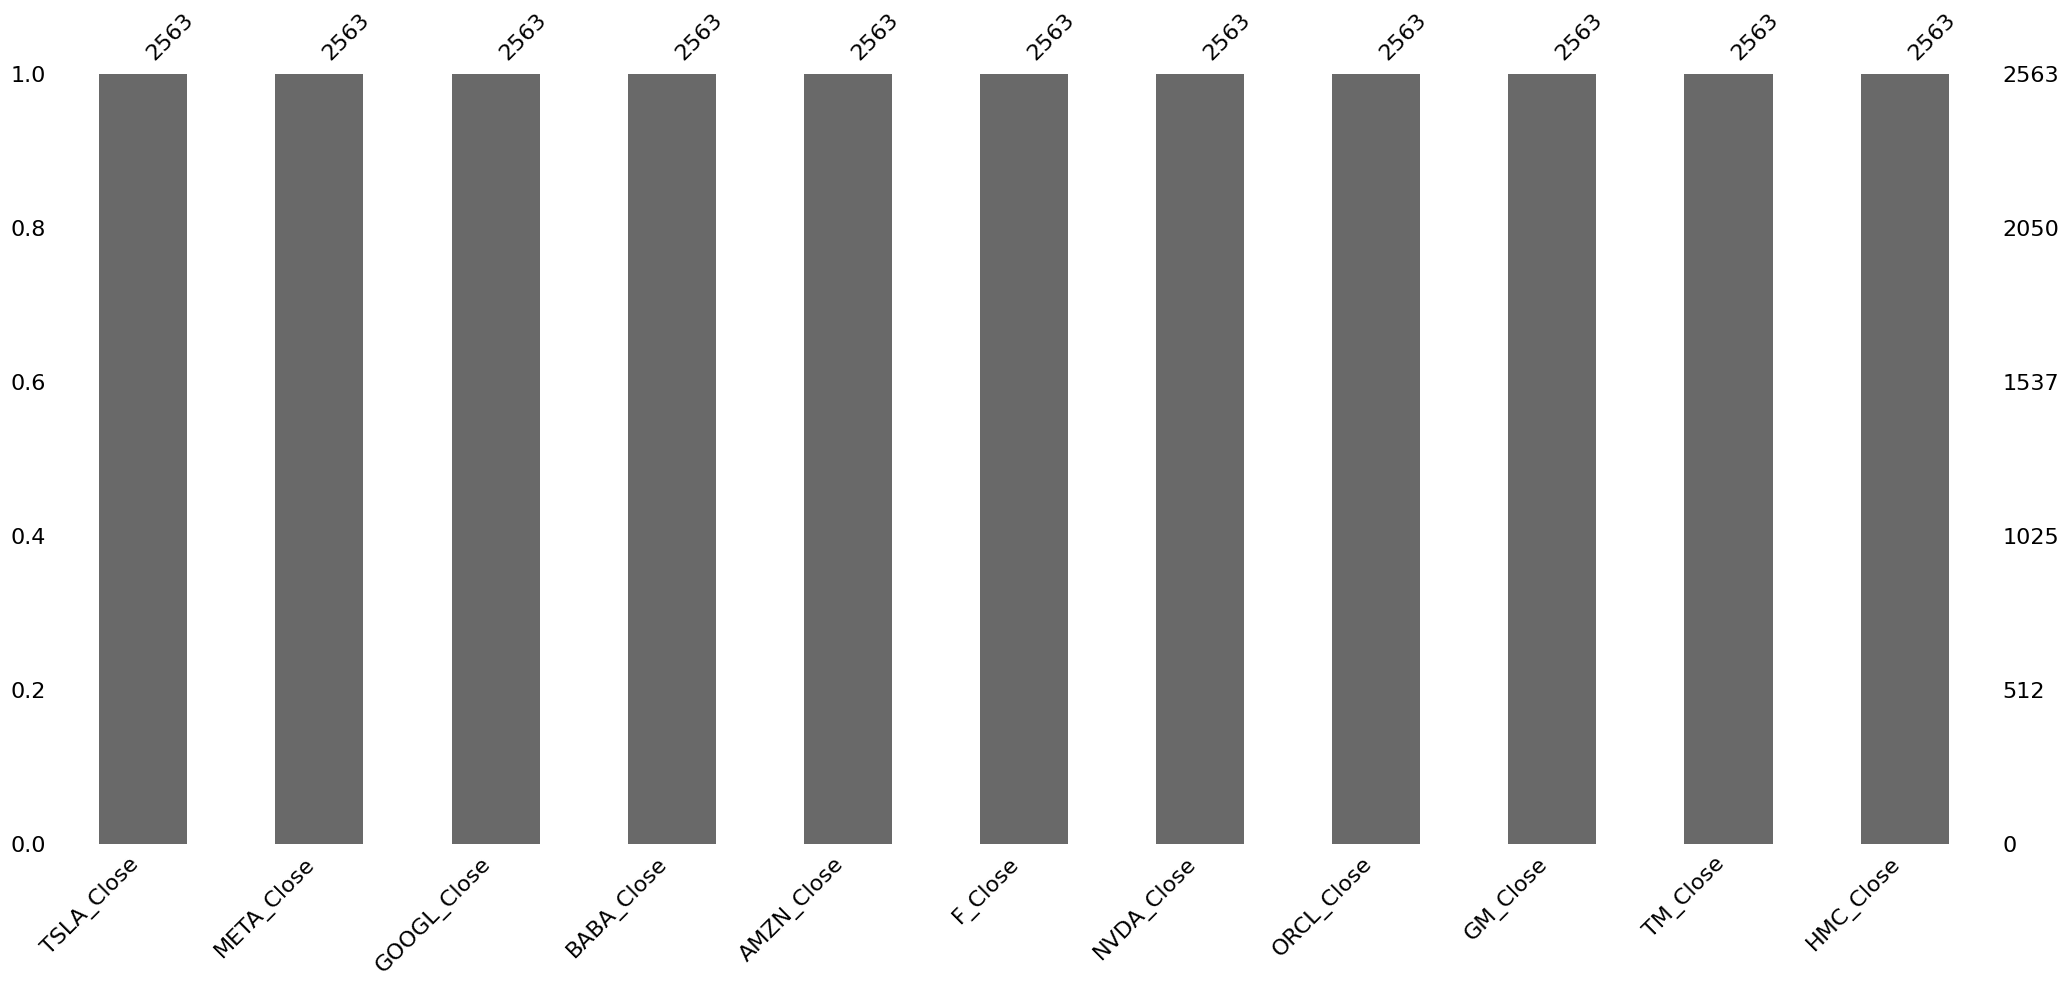

In [ ]:
# Visualisation des valeurs manquantes sous forme barplot avec le package "missingno"
msno.bar(data)
plt.show()

#### Standardisation

In [ ]:
data_stand = data.copy()
data_nor = data.copy()

In [ ]:
# Standardisation
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data_stand.columns, index=data_stand.index)

print(data_scaled.head())


                           TSLA_Close  META_Close  GOOGL_Close  BABA_Close  \
Date                                                                         
2015-01-02 00:00:00-05:00   -0.894576   -1.129702    -1.275768   -0.555246   
2015-01-05 00:00:00-05:00   -0.899790   -1.139070    -1.286832   -0.599275   
2015-01-06 00:00:00-05:00   -0.899117   -1.146803    -1.300890   -0.559987   
2015-01-07 00:00:00-05:00   -0.899304   -1.146803    -1.302524   -0.580139   
2015-01-08 00:00:00-05:00   -0.899491   -1.131709    -1.300594   -0.531029   

                           AMZN_Close   F_Close  NVDA_Close  ORCL_Close  \
Date                                                                      
2015-01-02 00:00:00-05:00   -1.569077 -0.035871   -0.633251   -0.791229   
2015-01-05 00:00:00-05:00   -1.574718 -0.181547   -0.633482   -0.805858   
2015-01-06 00:00:00-05:00   -1.580868 -0.215539   -0.633891   -0.816476   
2015-01-07 00:00:00-05:00   -1.578078 -0.113565   -0.633925   -0.816240   
201

#### Normalisation

In [ ]:
# Normalisation

# Création d'un objet MinMaxScaler
minmax_scaler = MinMaxScaler()

# Application de la normalisation Min-Max aux données
data_normalized = pd.DataFrame(minmax_scaler.fit_transform(data_nor),
                               columns=data_nor.columns,
                               index=data_nor.index)

# Afficher un aperçu des données normalisées
print(data_normalized.head())

                           TSLA_Close  META_Close  GOOGL_Close  BABA_Close  \
Date                                                                         
2015-01-02 00:00:00-05:00    0.010723    0.006612     0.008912    0.177902   
2015-01-05 00:00:00-05:00    0.009416    0.004719     0.006145    0.167892   
2015-01-06 00:00:00-05:00    0.009584    0.003156     0.002628    0.176824   
2015-01-07 00:00:00-05:00    0.009538    0.003156     0.002219    0.172243   
2015-01-08 00:00:00-05:00    0.009491    0.006206     0.002702    0.183407   

                           AMZN_Close   F_Close  NVDA_Close  ORCL_Close  \
Date                                                                      
2015-01-02 00:00:00-05:00    0.004736  0.339324    0.000160    0.051388   
2015-01-05 00:00:00-05:00    0.003346  0.318718    0.000105    0.048119   
2015-01-06 00:00:00-05:00    0.001831  0.313910    0.000008    0.045746   
2015-01-07 00:00:00-05:00    0.002519  0.328334    0.000000    0.045799   
201

## 3- Segmentation du marché boursier (Clustering)

#### Appliquer K-Means avec k=2

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
data_scaled["Cluster_KMeans"] = kmeans.fit_predict(data_scaled)

# Afficher le nombre d'actions dans chaque cluster
print(data_scaled["Cluster_KMeans"].value_counts())

# Visualiser les centres des clusters
print(pd.DataFrame(kmeans.cluster_centers_, columns=data.columns))


Cluster_KMeans
0    1738
1     825
Name: count, dtype: int64
   TSLA_Close  META_Close  GOOGL_Close  BABA_Close  AMZN_Close   F_Close  \
0   -0.562818   -0.527130    -0.598159    0.120644   -0.528919 -0.491566   
1    1.185670    1.110488     1.260121   -0.254156    1.114256  1.035566   

   NVDA_Close  ORCL_Close  GM_Close  TM_Close  HMC_Close  
0   -0.473790   -0.539645 -0.487918 -0.580571  -0.468815  
1    0.998118    1.136851  1.027881  1.223069   0.987637  


#### Nombre optimal de clusters avec Méthode du coude

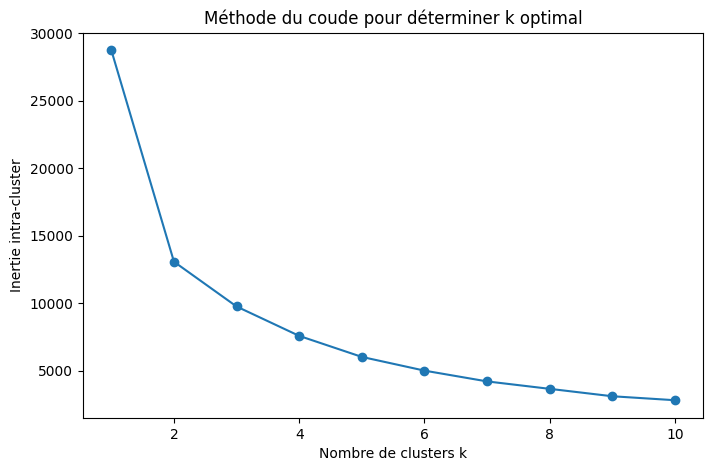

In [ ]:
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)

# Tracer la courbe du coude
plt.figure(figsize=(8,5))
plt.plot(K_range, inertia, marker='o', linestyle='-')
plt.xlabel("Nombre de clusters k")
plt.ylabel("Inertie intra-cluster")
plt.title("Méthode du coude pour déterminer k optimal")
plt.show()


#### Score de silhouette

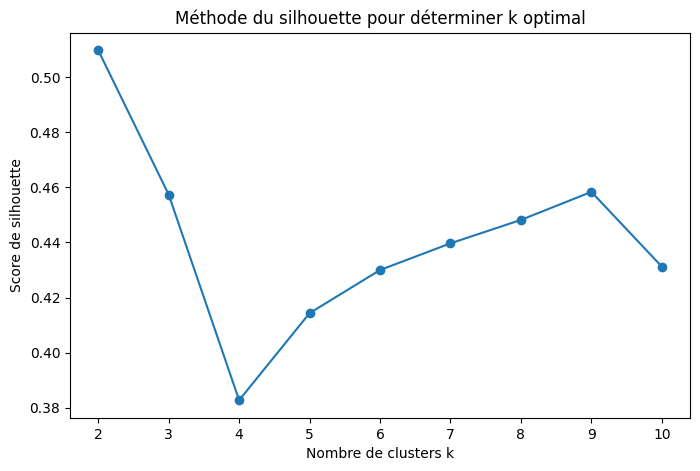

In [ ]:
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(data_scaled)
    silhouette_scores.append(silhouette_score(data_scaled, cluster_labels))

# Tracer le score de silhouette
plt.figure(figsize=(8,5))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='-')
plt.xlabel("Nombre de clusters k")
plt.ylabel("Score de silhouette")
plt.title("Méthode du silhouette pour déterminer k optimal")
plt.show()


#### Visualiser les clusters avec ACP

In [ ]:
print(data_scaled.columns)


Index(['TSLA_Close', 'META_Close', 'GOOGL_Close', 'BABA_Close', 'AMZN_Close',
       'F_Close', 'NVDA_Close', 'ORCL_Close', 'GM_Close', 'TM_Close',
       'HMC_Close', 'Cluster_KMeans'],
      dtype='object')


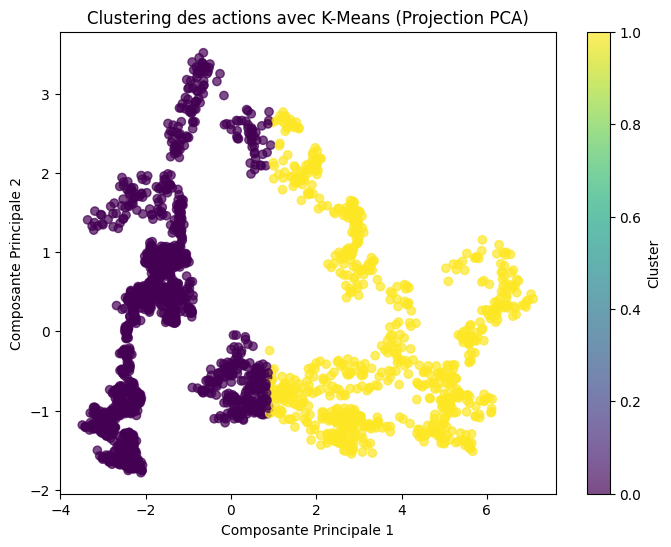

In [ ]:
from sklearn.decomposition import PCA

# Réduction de dimension avec ACP (2D)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_scaled.drop(["Cluster_KMeans"], axis=1))
data_scaled["PC1"] = pca_result[:,0]
data_scaled["PC2"] = pca_result[:,1]

# Tracer les clusters obtenus avec K-Means
plt.figure(figsize=(8,6))
plt.scatter(data_scaled["PC1"], data_scaled["PC2"], c=data_scaled["Cluster_KMeans"], cmap='viridis', alpha=0.7)
plt.xlabel("Composante Principale 1")
plt.ylabel("Composante Principale 2")
plt.title("Clustering des actions avec K-Means (Projection PCA)")
plt.colorbar(label="Cluster")
plt.show()


### Clusters des entreprises

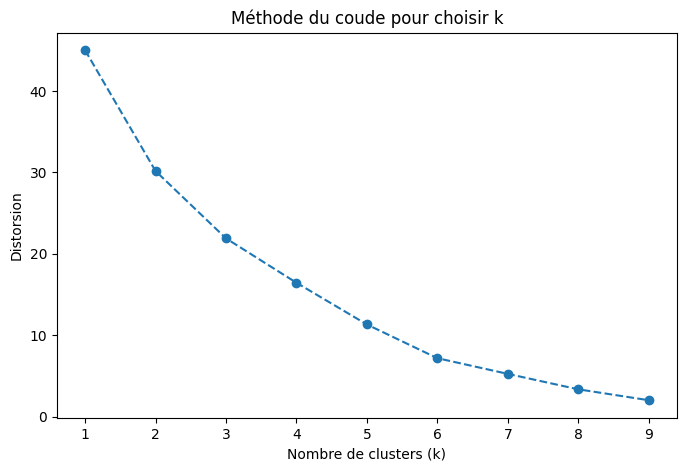

In [ ]:

df = data[['TSLA_Close', 'META_Close', 'GOOGL_Close', 'BABA_Close',
           'AMZN_Close', 'F_Close', 'NVDA_Close', 'ORCL_Close',
           'GM_Close', 'TM_Close', 'HMC_Close']]

# Standardiser les données pour éviter l'effet d'échelle
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df.T)  # Transposition pour regrouper les entreprises

# Trouver le nombre optimal de clusters avec la méthode du coude
distortions = []
K_range = range(1, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    distortions.append(sum(np.min(cdist(df_scaled, kmeans.cluster_centers_, 'euclidean'), axis=1)) / df_scaled.shape[0])

# Tracer la courbe du coude
plt.figure(figsize=(8, 5))
plt.plot(K_range, distortions, marker='o', linestyle='--')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Distorsion')
plt.title('Méthode du coude pour choisir k')
plt.show()

In [ ]:
# Appliquer K-Means avec le nombre optimal de clusters (ex: k=3)
k_optimal = 3  # Remplace par la meilleure valeur après analyse du coude
kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
clusters = kmeans.fit_predict(df_scaled)

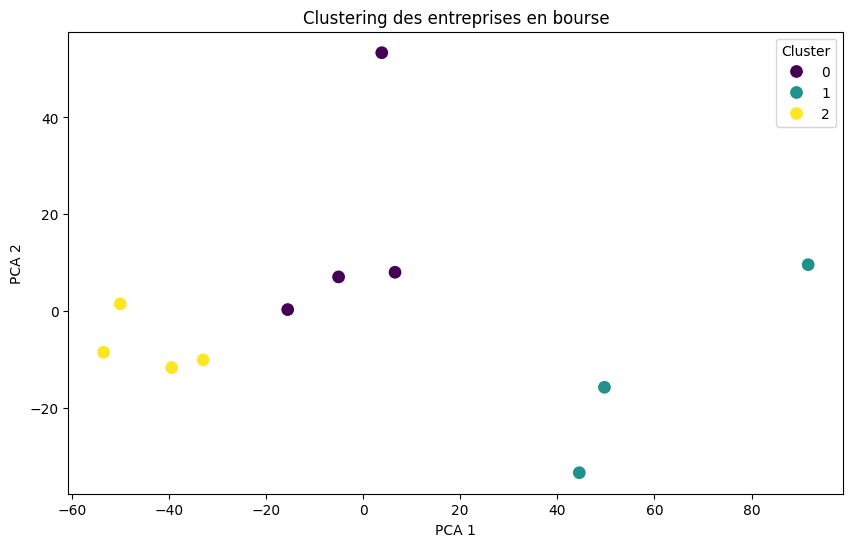

In [ ]:
# Ajouter les clusters au dataframe
df_clusters = pd.DataFrame(df.T)
df_clusters['Cluster'] = clusters

# Visualisation avec PCA (Réduction en 2D)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=clusters, palette='viridis', s=100)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Clustering des entreprises en bourse')
plt.legend(title='Cluster')
plt.show()



In [ ]:
# Affichage des entreprises et leurs clusters

# Trier les entreprises par cluster
df_clusters_sorted = df_clusters[['Cluster']].sort_values(by="Cluster")

# Afficher les résultats triés
print(df_clusters_sorted)


Date         Cluster
TSLA_Close         0
GOOGL_Close        0
ORCL_Close         0
AMZN_Close         0
BABA_Close         1
META_Close         1
TM_Close           1
F_Close            2
NVDA_Close         2
GM_Close           2
HMC_Close          2


## 4- Détection d’anomalies

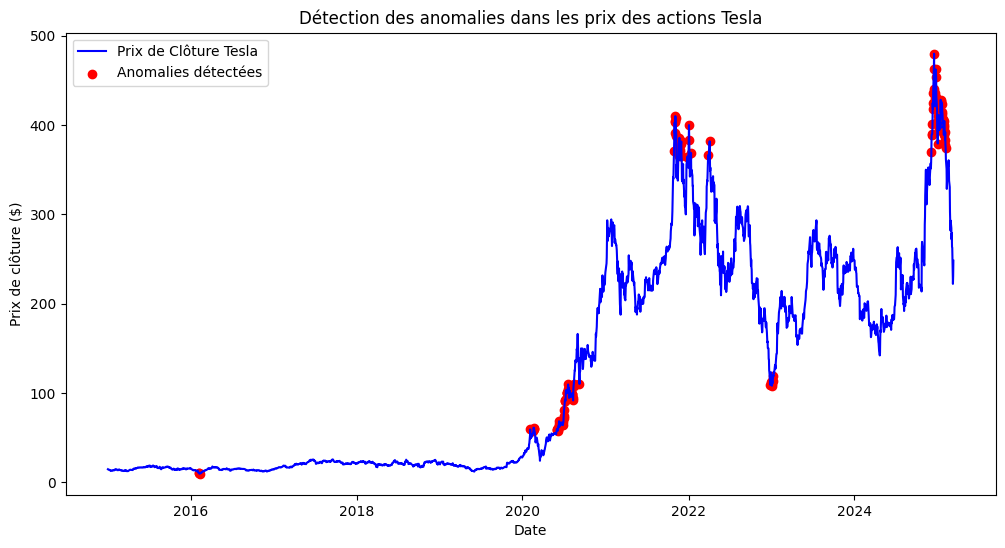

📌 Jours détectés comme anomalies :
                           TSLA_Close
Date                                 
2016-02-08 00:00:00-05:00    9.866000
2016-02-09 00:00:00-05:00    9.883333
2016-02-10 00:00:00-05:00    9.578000
2020-02-04 00:00:00-05:00   59.137333
2020-02-18 00:00:00-05:00   57.226665
...                               ...
2025-01-31 00:00:00-05:00  404.600006
2025-02-03 00:00:00-05:00  383.679993
2025-02-04 00:00:00-05:00  392.209991
2025-02-05 00:00:00-05:00  378.170013
2025-02-06 00:00:00-05:00  374.320007

[129 rows x 1 columns]


In [ ]:

from sklearn.ensemble import IsolationForest

# Charger les données (supposons que 'data' contient déjà les prix des actions)
df_tesla = data[['TSLA_Close']].copy()  # On travaille d'abord sur Tesla

# Paramètres du modèle Isolation Forest
model = IsolationForest(contamination=0.05, random_state=42)  # 5% de contamination = anomalies

# Appliquer le modèle sur les prix de Tesla
df_tesla['Anomaly'] = model.fit_predict(df_tesla)

# Filtrer les anomalies (-1 = anomalie détectée)
anomalies = df_tesla[df_tesla['Anomaly'] == -1]

# Visualisation des anomalies sur la courbe des prix
plt.figure(figsize=(12,6))
plt.plot(df.index, df_tesla['TSLA_Close'], label='Prix de Clôture Tesla', color='blue')
plt.scatter(anomalies.index, anomalies['TSLA_Close'], color='red', label='Anomalies détectées', marker='o')
plt.xlabel('Date')
plt.ylabel('Prix de clôture ($)')
plt.title('Détection des anomalies dans les prix des actions Tesla')
plt.legend()
plt.show()

# Afficher les dates et prix des anomalies
print("📌 Jours détectés comme anomalies :")
print(anomalies[['TSLA_Close']])


# PARTIE B : PRÉVISION DES ACTIONS DE TESLA

In [ ]:
# Charger les données de Tesla (TSLA_Close)
df_tesla = data[['TSLA_Close']].copy()

#  Statistiques descriptives
print("Statistiques Descriptives de Tesla :")
print(df_tesla.describe())

Statistiques Descriptives de Tesla :
        TSLA_Close
count  2563.000000
mean    120.068665
std     117.897874
min       9.578000
25%      17.332999
50%      34.933334
75%     224.040001
max     479.859985


#### Test de normalité

<Axes: ylabel='Density'>

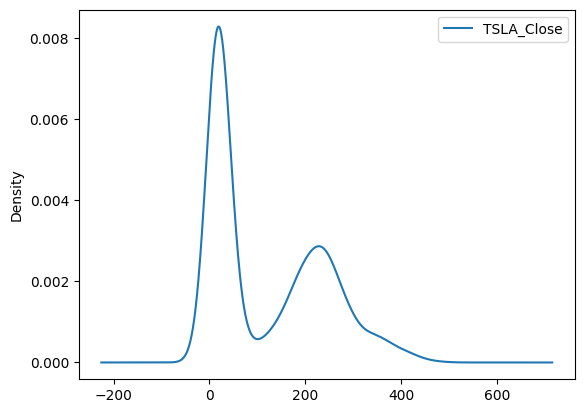

In [ ]:
df_tesla.plot(kind= "density")

In [ ]:
df_tesla.skew() #la distribution(repartition) n'est pas symetrique (skew>0), elle est decallée vers la droite

,0
TSLA_Close,0.645382


In [ ]:
import scipy.stats
scipy.stats.shapiro(df_tesla)[1]  #H0: la variable suit la loi normale, c'est à dire elle est issue du hasard

np.float64(2.1402114968717087e-47)

### Dispersion ou coefficient de variation

In [ ]:
dispersion_moyenne=data["TSLA_Close"].std()/data["TSLA_Close"].mean()*100  #dispersion=std/mean*100
dispersion_moyenne

np.float64(98.19204154543405)

In [ ]:
dispersion=data.std(numeric_only=True)/data.mean(numeric_only=True)*100
#dispersion=data.std(numeric_only=True)/data.mean(numeric_only=True)*100

dispersion.sort_values()

,0
HMC_Close,13.362794
TM_Close,21.564601
GM_Close,25.942946
F_Close,26.564158
BABA_Close,43.304911
GOOGL_Close,53.876792
AMZN_Close,54.239593
ORCL_Close,54.524644
META_Close,58.388560
TSLA_Close,98.192042


<Axes: >

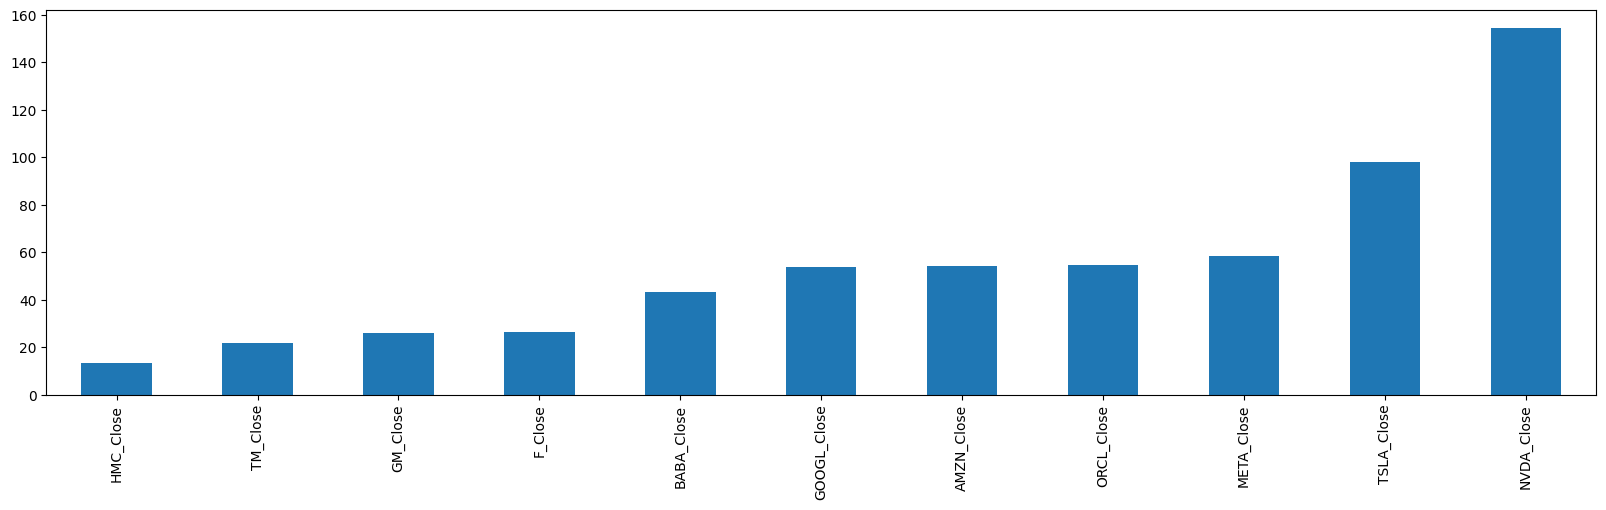

In [ ]:
dispersion.sort_values().plot(kind="bar", figsize=(20,5))

Nous pouvons remarquer un taux de disperssion (98.192042) > 50% qui indique que les actions de tesla sont très dispersé dans le temps. Le prix des actions de Tesla evolue fortement depuis 2015.

## 1. Analyse des données de Tesla

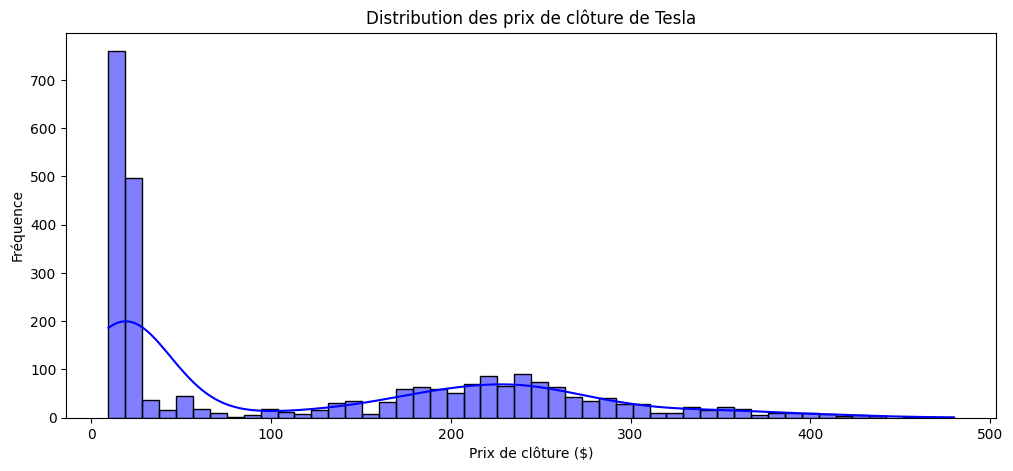

In [ ]:
#  Visualisation de la distribution des prix
plt.figure(figsize=(12,5))
sns.histplot(df_tesla['TSLA_Close'], bins=50, kde=True, color='blue')
plt.title("Distribution des prix de clôture de Tesla")
plt.xlabel("Prix de clôture ($)")
plt.ylabel("Fréquence")
plt.show()

In [ ]:
#  Test de normalité de Shapiro-Wilk
stat, p = shapiro(df_tesla['TSLA_Close'])
print(f"Test de Shapiro-Wilk: Statistique={stat:.3f}, p-valeur={p:.5f}")

#  Interprétation
if p > 0.05:
    print(" Les prix des actions suivent une distribution normale (p > 0.05)")
else:
    print(" Les prix ne suivent PAS une distribution normale (p < 0.05)")


Test de Shapiro-Wilk: Statistique=0.815, p-valeur=0.00000
 Les prix ne suivent PAS une distribution normale (p < 0.05)


### Vérification de la stationnarité (Test de Dickey-Fuller)

In [ ]:
# Test de stationnarité (Dickey-Fuller)
result = adfuller(df_tesla['TSLA_Close'])
print(f"Test de Dickey-Fuller : Statistique={result[0]:.3f}, p-valeur={result[1]:.5f}")

#  Interprétation
if result[1] < 0.05:
    print("La série est stationnaire (p < 0.05)")
else:
    print(" La série n'est PAS stationnaire (p > 0.05) - Transformation nécessaire")

# H₀ (hypothèse nulle) : La série n’est pas stationnaire (elle a une racine unitaire).

# H₁ (hypothèse alternative) : La série est stationnaire.


Test de Dickey-Fuller : Statistique=-1.521, p-valeur=0.52317
 La série n'est PAS stationnaire (p > 0.05) - Transformation nécessaire


<Axes: xlabel='Date'>

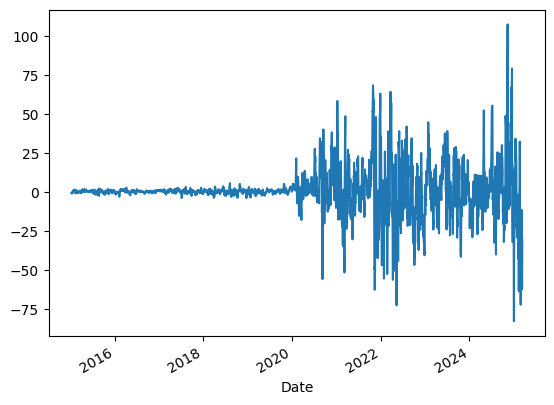

In [ ]:
y=data["TSLA_Close"].diff(5)
y.plot()

In [ ]:
from statsmodels.tsa.stattools import adfuller as DukeyFuller_test
DukeyFuller_test(data["TSLA_Close"])[1]

np.float64(0.5231691402263818)

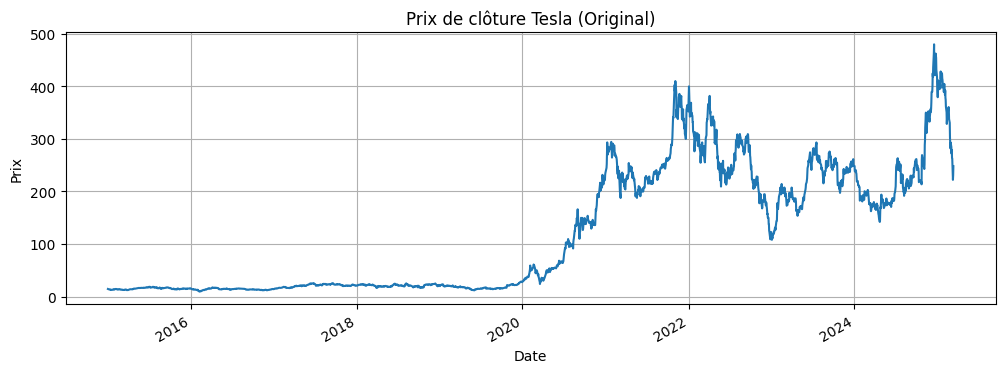

In [ ]:
import matplotlib.pyplot as plt

# Tracer la série originale
data['TSLA_Close'].plot(figsize=(12, 4), title='Prix de clôture Tesla (Original)', ylabel='Prix')
plt.grid(True)
plt.show()


### Différenciation de la série (rendre la série stationnaire)

Date
2015-01-05 00:00:00-05:00   -0.614668
2015-01-06 00:00:00-05:00    0.079333
2015-01-07 00:00:00-05:00   -0.022000
2015-01-08 00:00:00-05:00   -0.021999
2015-01-09 00:00:00-05:00   -0.264000
Name: TSLA_Close, dtype: float64


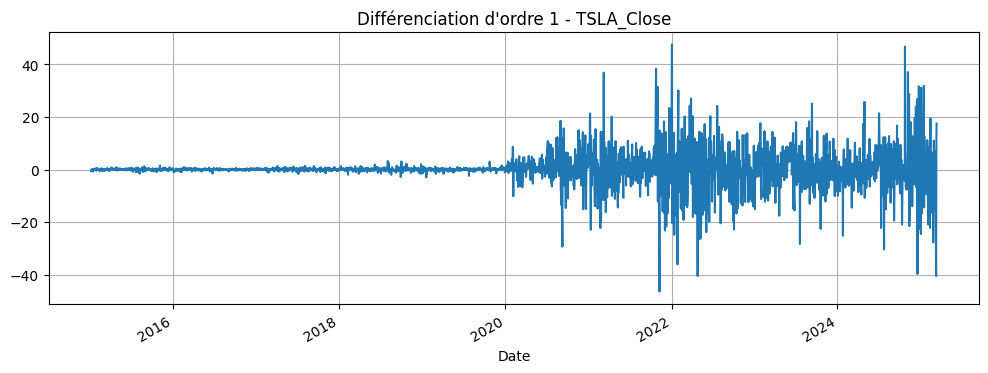

In [ ]:
tsla_diff = data['TSLA_Close'].diff().dropna()

# Afficher un aperçu
print(tsla_diff.head())

# Tracer la série différenciée
tsla_diff.plot(figsize=(12, 4), title='Différenciation d\'ordre 1 - TSLA_Close')
plt.grid(True)
plt.show()


In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(tsla_diff)
print(f"ADF Statistic : {result[0]}")
print(f"p-value : {result[1]}")


ADF Statistic : -8.970320931463869
p-value : 7.785584923106454e-15


## 2. Modèle ARIMA, SARIMA

#### ARIMA(p,d,q) – sans saisonnalité

In [ ]:
"""from pmdarima.arima import auto_arima

auto_model = auto_arima(df['TSLA_Close'], seasonal=False, trace=True)
print(auto_model.summary())


ModuleNotFoundError: No module named 'pmdarima'

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model_arima = SARIMAX(df['TSLA_Close'], order=auto_model.order)
results_arima = model_arima.fit(disp=False)

print(results_arima.summary())
results_arima.plot_diagnostics(figsize=(12,6))


#### SARIMA(p,d,q)(P,D,Q,s) – avec saisonnalité

In [ ]:
# On extrait la série temporelle Tesla (avec index = Date)
y = data['TSLA_Close'].asfreq('B')  # 'B' = jours ouvrés (marché boursier)

# Si la série a des valeurs manquantes, on les impute par interpolation
y = y.interpolate()


##### Trouver automatiquement les meilleurs paramètres SARIMA avec auto_arima


In [ ]:
# Recherche automatique des paramètres optimaux (p,d,q)(P,D,Q,s)
auto_model = pm.auto_arima(
    y,
    start_p=0, max_p=5,
    start_q=0, max_q=5,
    start_d=0, max_d=2,
    start_P=0, max_P=3,
    start_Q=0, max_Q=3,
    start_D=0, max_D=2,
    m=21,  # ≈ 1 mois boursier (21 jours ouvrés)
    seasonal=True,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

# Afficher les meilleurs paramètres
print("Meilleurs paramètres trouvés :", auto_model.order, auto_model.seasonal_order)


NameError: name 'pm' is not defined

##### Construire le modèle SARIMA avec les meilleurs paramètres

In [ ]:
# Extraire les paramètres recommandés
p, d, q = auto_model.order
P, D, Q, s = auto_model.seasonal_order

# Créer le modèle SARIMA
model = SARIMAX(y, order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit()

# Résumé des résultats
print(results.summary())


##### Visualiser les prédictions vs données réelles

In [ ]:
# Prédiction sur les 30 prochains jours
forecast = results.get_forecast(steps=30)
conf_int = forecast.conf_int()

# Tracer les résultats
plt.figure(figsize=(15, 5))
plt.plot(y, label="Données historiques")
plt.plot(forecast.predicted_mean, label="Prévisions")
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='lightblue', alpha=0.4)
plt.title("Prévision du prix de l'action Tesla avec SARIMA")
plt.xlabel("Date")
plt.ylabel("Prix de clôture")
plt.legend()
plt.show()


##### Precision du modele

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

# Étape 1 : Prédiction sur les 119 prochains jours
steps_a_predire = 119
predictions = results.forecast(steps=steps_a_predire)

# Étape 2 : Récupérer les vraies valeurs correspondantes (si disponibles)
# On suppose que 'data' contient les vraies valeurs futures de 'TSLA_Close'
# Décaler pour que les index correspondent
date_debut = predictions.index[0]
date_fin = predictions.index[-1]

# Vérifier si on a les vraies valeurs dans la base (sinon on peut les simuler ou ignorer l'évaluation)
if date_fin in data.index:
    reel = data.loc[date_debut:date_fin, 'TSLA_Close']
else:
    print(" Pas de vraies valeurs disponibles pour les dates de prédiction. Comparaison partielle.")
    reel = data['TSLA_Close'].iloc[-steps_a_predire:]  # on prend les dernières valeurs disponibles

# Étape 3 : Créer le DataFrame de comparaison
resultats = pd.DataFrame(index=predictions.index)
resultats['reel'] = reel.values[:steps_a_predire]
resultats['pred'] = predictions.values[:steps_a_predire]
resultats['erreur relative (%)'] = abs((resultats['pred'] - resultats['reel']) / resultats['reel']) * 100

# Étape 4 : Calcul des métriques
mae = mean_absolute_error(resultats['reel'], resultats['pred'])
mse = mean_squared_error(resultats['reel'], resultats['pred'])
rmse = np.sqrt(mse)
mape = np.mean(np.abs((resultats['reel'] - resultats['pred']) / resultats['reel'])) * 100

# Étape 5 : Affichage des résultats
print(" Évaluation du modèle SARIMA sur les données Tesla :")
print(f"MAE  = {mae:.2f}   Erreur absolue moyenne")
print(f"RMSE = {rmse:.2f}  Erreur quadratique moyenne")
print(f"MAPE = {mape:.2f}%  Erreur relative moyenne")

# Affichage aléatoire de 20 lignes du tableau de résultats
print("\n Échantillon des résultats :")
print(resultats.sample(20))


AttributeError: 'dict' object has no attribute 'forecast'

## 3. Test de causalité de Granger

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests

# Variables candidates à tester
candidates = ['META_Close', 'GOOGL_Close', 'AMZN_Close', 'NVDA_Close', 'BABA_Close']

# Préparer les données
df_granger = data[['TSLA_Close'] + candidates].copy()
df_granger = df_granger.asfreq('D').fillna(method='ffill')

# Test Granger (exemple pour 5 jours de lag)
for var in candidates:
    print(f"\nTest Granger: {var} → TSLA_Close")
    grangercausalitytests(df_granger[['TSLA_Close', var]], maxlag=5)


<ipython-input-46-c63b85c71e28>:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_granger = df_granger.asfreq('D').fillna(method='ffill')



Test Granger: META_Close → TSLA_Close

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.9829  , p=0.0842  , df_denom=3719, df_num=1
ssr based chi2 test:   chi2=2.9853  , p=0.0840  , df=1
likelihood ratio test: chi2=2.9841  , p=0.0841  , df=1
parameter F test:         F=2.9829  , p=0.0842  , df_denom=3719, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.6820  , p=0.0686  , df_denom=3716, df_num=2
ssr based chi2 test:   chi2=5.3713  , p=0.0682  , df=2
likelihood ratio test: chi2=5.3674  , p=0.0683  , df=2
parameter F test:         F=2.6820  , p=0.0686  , df_denom=3716, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.2597  , p=0.0795  , df_denom=3713, df_num=3
ssr based chi2 test:   chi2=6.7920  , p=0.0788  , df=3
likelihood ratio test: chi2=6.7858  , p=0.0790  , df=3
parameter F test:         F=2.2597  , p=0.0795  , df_denom=3713, df_num=3

Granger Causality
number of lags (no zero) 4
ssr

Les résultats du test de causalité de Granger montrent que les variations passées des actions AMZN et GOOGL ont une influence significative sur les prix de l’action TSLA, avec des p-values inférieures à 0,05 à tous les retards testés, ce qui indique qu’elles sont de bons prédicteurs de Tesla. NVDA présente également une relation significative, mais surtout avec des effets retardés aux lags 2, 4 et 5. En revanche, META n’a pas montré de relation significative, bien que ses p-values soient proches du seuil, ce qui suggère qu’une exploration plus approfondie pourrait être envisagée. Enfin, BABA n’a aucune capacité prédictive sur TSLA, avec des p-values très élevées. Il est donc recommandé d’intégrer AMZN, GOOGL et éventuellement NVDA dans un modèle multivarié pour prédire TSLA, tout en écartant BABA et en considérant META avec prudence.

## 4. SARIMAX

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Variable cible : prix de clôture de Tesla
target = data["TSLA_Close"]

# Variables exogènes ayant une influence prouvée (selon Granger)
exog = data[["AMZN_Close", "GOOGL_Close", "NVDA_Close"]].fillna(method="ffill")

# Nombre de points à garder pour le test (par ex. 20 derniers jours)
n = 20

# Séparation des données
train = target.iloc[:-n]
test = target.iloc[-n:]

exog_train = exog.iloc[:-n]
exog_test = exog.iloc[-n:]

# Paramètres SARIMAX trouvés comme optimaux
my_order = (0, 1, 0)
my_seasonal_order = (0, 0, 0, 21)

# Définir et entraîner le modèle SARIMAX
model = SARIMAX(train,
                exog=exog_train,
                order=my_order,
                seasonal_order=my_seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit()
print(results.summary())



<ipython-input-47-557fdd1af8c5>:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  exog = data[["AMZN_Close", "GOOGL_Close", "NVDA_Close"]].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             TSLA_Close   No. Observations:                 2543
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -8039.971
Date:                Mon, 14 Apr 2025   AIC                          16087.942
Time:                        19:25:02   BIC                          16111.303
Sample:                             0   HQIC                         16096.416
                               - 2543                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
AMZN_Close      0.6765      0.040     17.118      0.000       0.599       0.754
GOOGL_Close     0.6751      0.052     13.095      0.000       0.574       0.776
NVDA_Close      0.5222      0.061      8.547    

<Axes: ylabel='Density'>

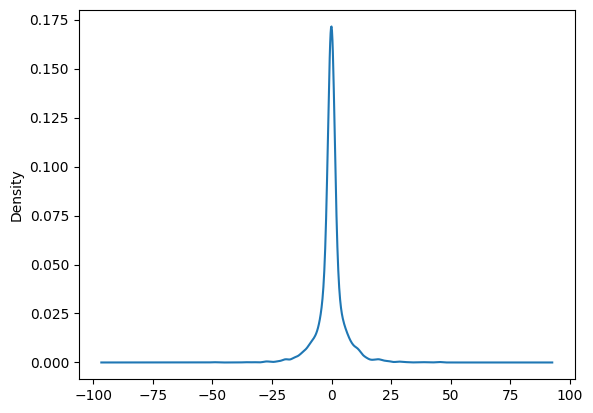

In [ ]:
results.resid.plot(kind="density")

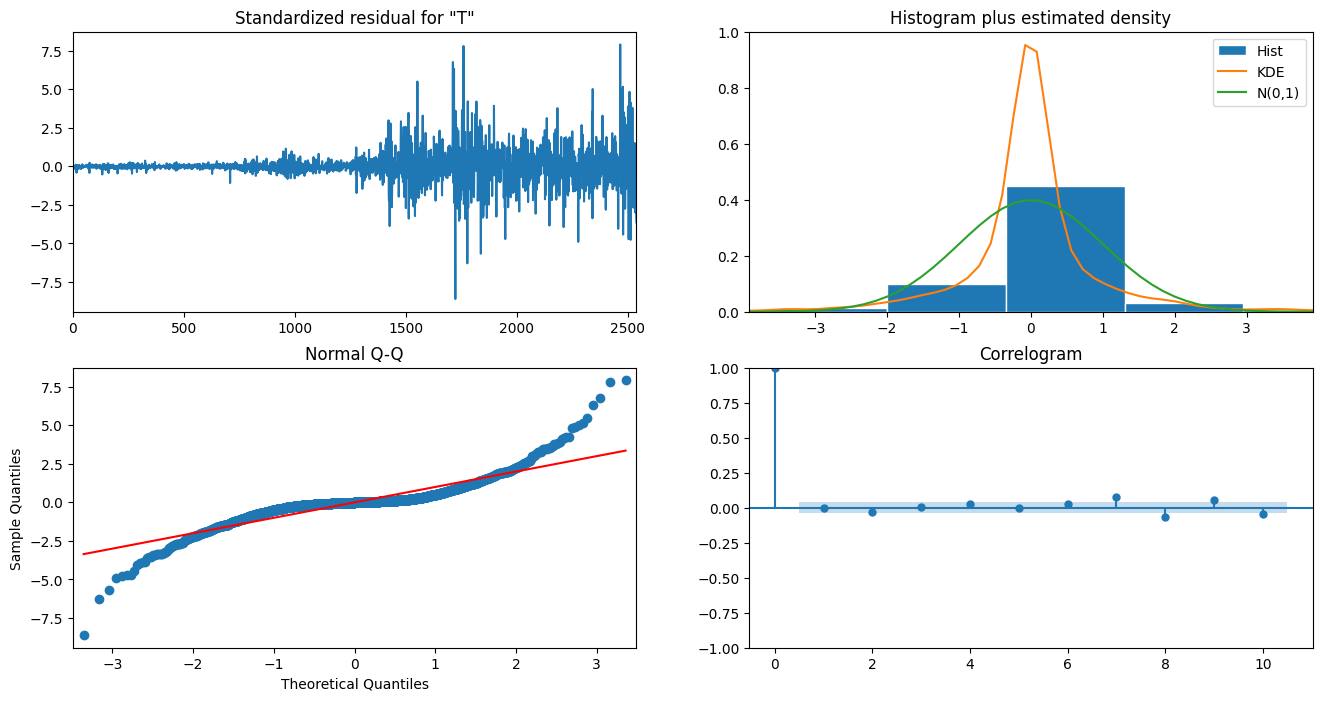

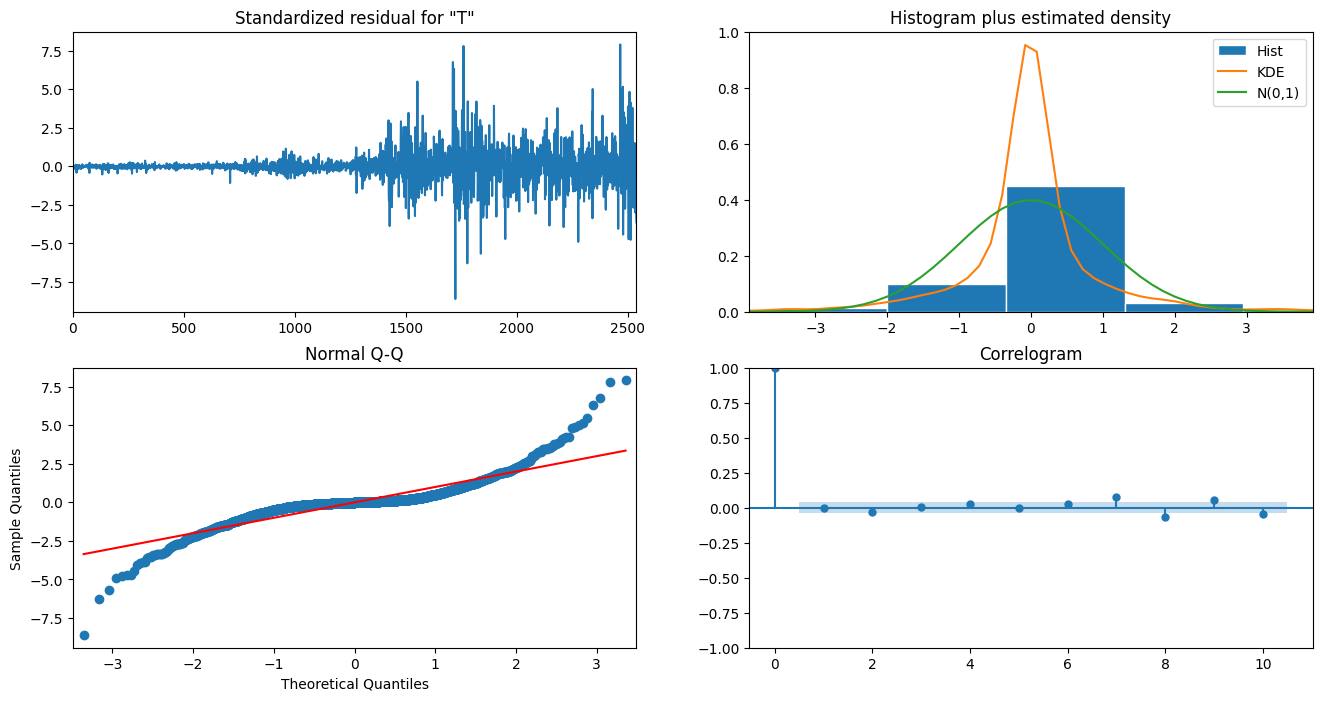

In [ ]:
results.plot_diagnostics(figsize=(16,8))

In [ ]:
# Faire une prédiction sur toute la série )
# Ici, on suppose que exog a la même longueur que target
predictions = results.forecast(steps=len(exog), start_index=target.index[0], exog=exog)
predictions


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_index']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


,predicted_mean
2543,5.209112
2544,4.651778
2545,3.980196
2546,4.035394
2547,4.172547
...,...
5101,286.457819
5102,287.601962
5103,276.175326
5104,277.256238


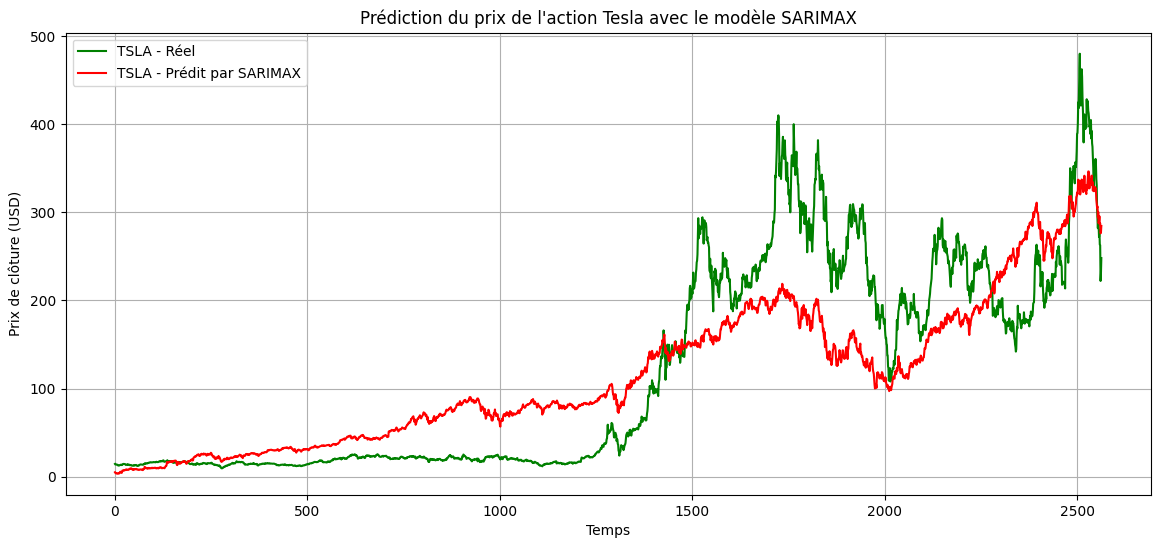

In [ ]:
# Stocker les prédictions
yhatsarimax = predictions

# Visualisation
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(target.values, label='TSLA - Réel', color='green')
plt.plot(predictions.values, label='TSLA - Prédit par SARIMAX', color='red')

plt.ylabel('Prix de clôture (USD)')
plt.xlabel('Temps')
plt.title("Prédiction du prix de l'action Tesla avec le modèle SARIMAX")
plt.legend(loc='best')
plt.grid()
plt.show()


La ligne verte représente le prix réel de l'action Tesla au fil du temps.

La ligne rouge montre les prix prédits par le modèle SARIMAX.

le modèle SARIMAX semble capter la tendance générale du prix de l'action Tesla, mais il a du mal à prédire les fluctuations à court terme et sous-estime parfois le prix réel.

On peut également remarquer que le modèle a du mal à prédire les pics et les creux du prix de l'action. Dans les périodes de forte volatilité, avec des variations rapides et importantes du prix, le modèle SARIMAX semble moins performant. Il lisse les variations et ne parvient pas à capturer les mouvements brusques.

In [ ]:
st.shapiro(results.resid)[1]

AttributeError: 'dict' object has no attribute 'resid'

#### Performance du modèle

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# On récupère les n dernières valeurs réelles et prédites
y_pred5 = predictions.values[-n:]  # Prédictions des n derniers jours/mois
y_true5 = target.values[-n:]       # Valeurs réelles correspondantes

# Calcul des métriques
mae = mean_absolute_error(y_true5, y_pred5)
mse = mean_squared_error(y_true5, y_pred5)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true5 - y_pred5) / y_true5)) * 100  # attention ici, divise par y_true5

# Affichage des résultats
print('MAE  =', mae)    # Erreur absolue moyenne
print('MSE  =', mse)    # Erreur quadratique moyenne
print('RMSE =', rmse)   # Racine de l'erreur quadratique
print('MAPE =', mape, '%')  # Erreur relative en pourcentage
print('_________________________________________')
print(f"Précision du modèle SARIMAX : {100 - mape:.2f} %")

MAE  = 23.074792148797485
MSE  = 697.8893248951799
RMSE = 26.41759498696238
MAPE = 8.082722976992489 %
_________________________________________
Précision du modèle SARIMAX : 91.92 %


#### Intervalle de confiance

In [ ]:
# Obtenir les prédictions avec les intervalles de confiance
predictions = results.get_forecast(steps=n, exog=exog_test).summary_frame()

# Aligner les index : on utilise les mêmes que pour exog_test
predictions.index = exog_test.index

# Ajouter les valeurs réelles de Tesla (prix de clôture)
predictions["reel"] = target[-n:].values

# Afficher le DataFrame final
predictions


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


TSLA_Close,mean,mean_se,mean_ci_lower,mean_ci_upper,reel
Date,,,,,
2025-02-12 00:00:00-05:00,323.889099,5.726824,312.664730,335.113469,336.510010
2025-02-13 00:00:00-05:00,328.736110,8.098952,312.862455,344.609765,355.940002
2025-02-14 00:00:00-05:00,328.837953,9.919150,309.396776,348.279130,355.839996
2025-02-18 00:00:00-05:00,326.767304,11.453648,304.318566,349.216042,354.109985
2025-02-19 00:00:00-05:00,327.676458,12.805568,302.578006,352.774910,360.559998
2025-02-20 00:00:00-05:00,325.120202,14.027797,297.626225,352.614179,354.399994
2025-02-21 00:00:00-05:00,314.588302,15.151752,284.891413,344.285192,337.799988
2025-02-24 00:00:00-05:00,309.526820,16.197905,277.779510,341.274130,330.529999
2025-02-25 00:00:00-05:00,305.099383,17.180472,271.426276,338.772490,302.799988


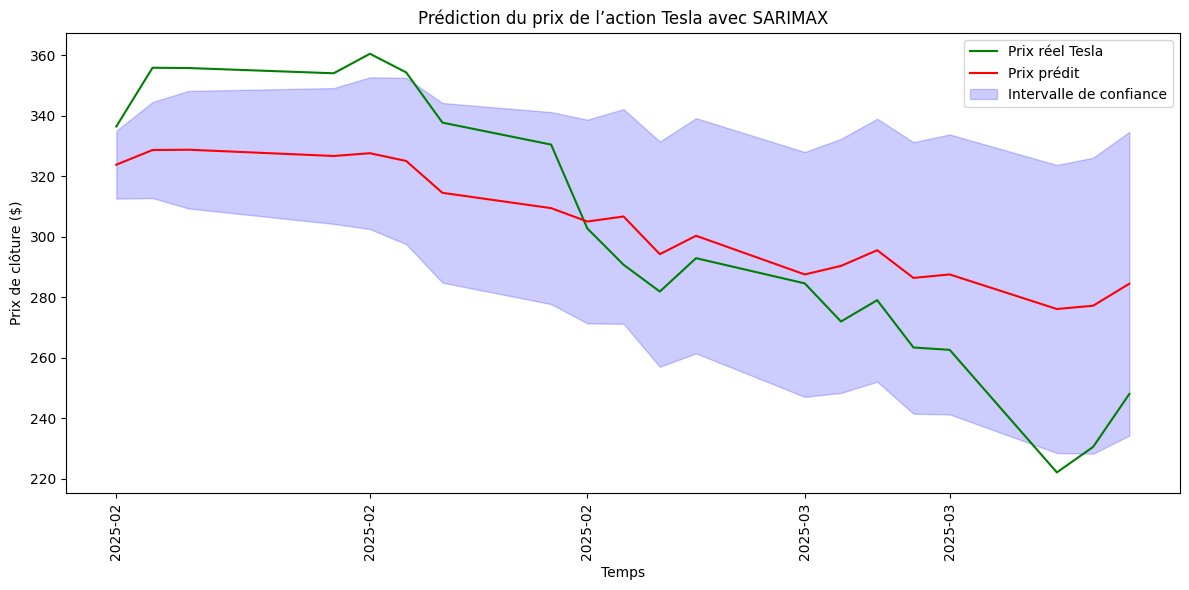

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12,6)

# Tracer les prix réels
plt.plot(predictions[['reel']], label='Prix réel Tesla', color='green')

# Tracer les prédictions
plt.plot(predictions[['mean']], label='Prix prédit', color='red')

# Tracer l'intervalle de confiance (zone entre min et max)
plt.fill_between(predictions.index,
                 predictions['mean_ci_lower'],
                 predictions['mean_ci_upper'],
                 color='blue', alpha=0.2, label='Intervalle de confiance')

# Titres et axes
plt.ylabel('Prix de clôture ($)')
plt.xlabel('Temps')
plt.title('Prédiction du prix de l’action Tesla avec SARIMAX')

# Ticks & rotation
plt.xticks(ticks=predictions.index[::4], labels=predictions.index[::4].strftime('%Y-%m'), rotation=90)

# Légende
plt.legend(loc='best')

# Affichage
plt.tight_layout()
plt.show()


#### Prédiction pour d'autres dates

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Définir la cible et les exogènes
target = data["TSLA_Close"]
exog = data[["AMZN_Close", "GOOGL_Close", "NVDA_Close"]]

# Paramètres de prédiction
n = 12  # nb d'observations qu'on garde pour test (pas utilisé ici pour prédictions futures)
NBMOIS = 24  # prédictions sur les 24 mois suivants

# Création des ensembles d'entraînement
train = target.head(len(target) - n)
exog_train = exog.head(len(target) - n)

# Paramètres SARIMAX optimaux (à adapter si besoin)
p, d, q = 0, 1, 0
P, D, Q, s = 0, 0, 0, 21



In [ ]:
# Étape 1 : Prédire les futures valeurs exogènes
predicted_exog = {}
for var in exog.columns:
    print(f"Training SARIMAX for {var}...")

    model_exog = SARIMAX(exog_train[var],
                         order=(p, d, q),
                         seasonal_order=(P, D, Q, s))

    results_exog = model_exog.fit(disp=False)
    predicted_exog[var] = results_exog.forecast(steps=NBMOIS)

# Convertir en DataFrame
predicted_exog_df = pd.DataFrame(predicted_exog)



Training SARIMAX for AMZN_Close...
Training SARIMAX for GOOGL_Close...
Training SARIMAX for NVDA_Close...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/

In [ ]:
# Étape 2 : Modèle SARIMAX principal pour Tesla
print("Training SARIMAX for Tesla...")

model_tsla = SARIMAX(train,
                     exog=exog_train,
                     order=(p, d, q),
                     seasonal_order=(P, D, Q, s))

results_tsla = model_tsla.fit(disp=False)

Training SARIMAX for Tesla...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
# Étape 3 : Prédiction du prix Tesla sur 24 mois
predictions = results_tsla.forecast(steps=NBMOIS, exog=predicted_exog_df)

# Résultat
print("Prédictions futures sur 24 mois :")
print(predictions)


Prédictions futures sur 24 mois :
2551    330.529999
2552    330.529999
2553    330.529999
2554    330.529999
2555    330.529999
2556    330.529999
2557    330.529999
2558    330.529999
2559    330.529999
2560    330.529999
2561    330.529999
2562    330.529999
2563    330.529999
2564    330.529999
2565    330.529999
2566    330.529999
2567    330.529999
2568    330.529999
2569    330.529999
2570    330.529999
2571    330.529999
2572    330.529999
2573    330.529999
2574    330.529999
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


### Visualisation des préduction

## 4. Modèle Facebook Prophet


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphexthjzo/5yyqfmmu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphexthjzo/32qf7q25.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84088', 'data', 'file=/tmp/tmphexthjzo/5yyqfmmu.json', 'init=/tmp/tmphexthjzo/32qf7q25.json', 'output', 'file=/tmp/tmphexthjzo/prophet_modelrwtd6ti_/prophet_model-20250414192708.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:27:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:27:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, 

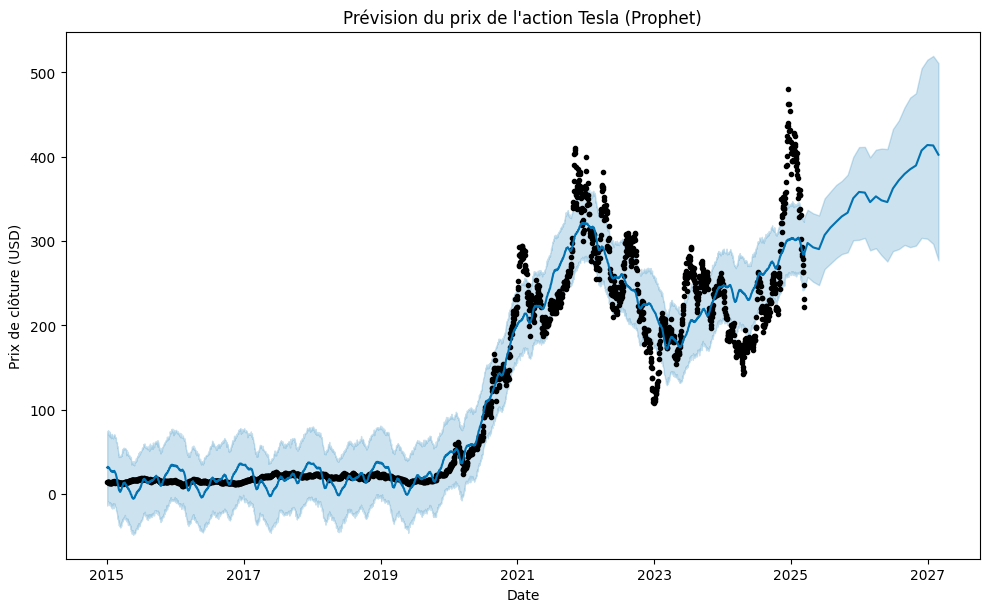

In [ ]:


# Réinitialiser l'index pour que la date soit une colonne
df_prophet = data.reset_index()[['Date', 'TSLA_Close']].copy()

# Renommer les colonnes comme attendu par Prophet
df_prophet.rename(columns={'Date': 'ds', 'TSLA_Close': 'y'}, inplace=True)

# S'assurer que les dates sont bien en format datetime et supprimer le fuseau horaire
df_prophet['ds'] = pd.to_datetime(df_prophet['ds']).dt.tz_localize(None) #This line removes the timezone

# Créer et entraîner le modèle Prophet
model = Prophet()
model.fit(df_prophet)

# Créer les futures dates à prédire (24 mois dans le futur)
future = model.make_future_dataframe(periods=24, freq='M')

# Prédiction
forecast = model.predict(future)

# Visualisation
fig = model.plot(forecast)
plt.title("Prévision du prix de l'action Tesla (Prophet)")
plt.xlabel("Date")
plt.ylabel("Prix de clôture (USD)")
plt.grid()
plt.show()

Le graphique montre les résultats de la prévision du prix de l'action Tesla réalisée avec le modèle Prophet. Sur ce graphique, les points noirs correspondent aux valeurs réelles du prix de clôture de l'action Tesla au fil du temps. La ligne bleue représente les prédictions du modèle, c’est-à-dire ce qu’il estime comme prix futur de l’action. Autour de cette ligne, on voit une zone bleue claire qui correspond à l’intervalle de confiance. Cela signifie que, selon le modèle, il est très probable que le vrai prix se trouve à l’intérieur de cette zone.

En regardant le graphique, on peut voir que le modèle Prophet suit plutôt bien la tendance générale du prix de Tesla. La courbe bleue suit les mouvements principaux des points noirs, ce qui montre que le modèle capte bien la direction du marché. Toutefois, il y a des moments où la prédiction s’éloigne de la réalité, ce qui indique que le modèle peut parfois manquer de précision.

On remarque aussi que la zone d’incertitude devient plus large lorsque le marché est instable. Cela reflète le fait que le modèle est moins sûr de ses prédictions lorsqu’il y a beaucoup de variations imprévues.

En conclusion, Prophet est un bon outil pour estimer la tendance générale du prix de l’action Tesla sur le long terme. Cependant, comme tous les modèles, il a des limites, notamment pour prévoir les changements brusques ou les événements exceptionnels du marché.

## 5. Modèle LSTM

In [ ]:

# 1. Préparation des données (en supposant que 'data' et 'features' sont définis comme dans le code précédent)
features = ['TSLA_Close', 'AMZN_Close', 'GOOGL_Close', 'NVDA_Close']
data = data[features].dropna()

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# 2. Création des séquences (fenêtres glissantes)
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i, 0])  # TSLA_Close est la 1ère colonne
    return np.array(X), np.array(y)

SEQ_LEN = 60  # par exemple, 60 jours
X, y = create_sequences(scaled_data, SEQ_LEN)

# 3. Split train/test
split = int(len(X) * 0.9)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 4. Construction du modèle LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 60, 50)         │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,251 (122.07 KB)

 Trainable params: 31,251 (122.07 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 5. Entraînement
history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_test, y_test), shuffle=False)

# 6. Prédictions
predictions = model.predict(X_test)




Epoch 1/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 0.0032 - val_loss: 0.0216
Epoch 2/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0018 - val_loss: 0.0202
Epoch 3/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0025 - val_loss: 0.0360
Epoch 4/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 0.0048 - val_loss: 0.0353
Epoch 5/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.0032 - val_loss: 0.0504
Epoch 6/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0027 - val_loss: 0.0748
Epoch 7/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 0.0022 - val_loss: 0.0653
Epoch 8/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 9.5418e-04 - val_loss: 0.0507
Epoch 9/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 8.5661e-04 - val_loss: 0.0447
Epoch 10/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - loss: 7.2812e-04 - val_loss: 0.0473
Epoch 11/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0010 - val_loss: 0.0339
Epoch 12/15
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step

In [ ]:
# 7. Inverse scaling
predicted_prices = scaler.inverse_transform(np.hstack((predictions, np.zeros((predictions.shape[0], scaled_data.shape[1]-1)))))[:,0]
real_prices = scaler.inverse_transform(np.hstack((y_test.reshape(-1,1), np.zeros((y_test.shape[0], scaled_data.shape[1]-1)))))[:,0]

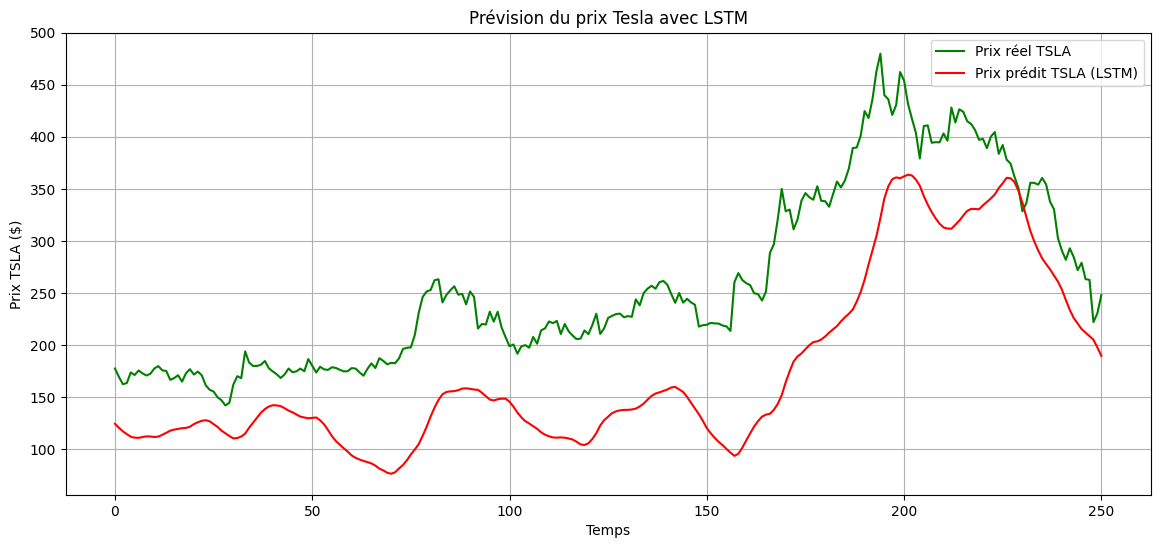

In [ ]:
# 8. Visualisation
plt.figure(figsize=(14,6))
plt.plot(real_prices, color='green', label='Prix réel TSLA')
plt.plot(predicted_prices, color='red', label='Prix prédit TSLA (LSTM)')
plt.title("Prévision du prix Tesla avec LSTM")
plt.xlabel("Temps")
plt.ylabel("Prix TSLA ($)")
plt.legend()
plt.grid()
plt.show()

Le graphique montre la prédiction du prix de l’action Tesla faite avec un modèle LSTM. La ligne verte correspond au prix réel, tandis que la ligne rouge montre la prédiction du modèle.

On remarque que la courbe rouge est plus lisse que la courbe verte. Cela signifie que le modèle LSTM a parfois du mal à suivre les variations rapides du prix réel. Il réagit souvent avec un petit retard, ce qui fait que les hausses ou les baisses soudaines ne sont pas bien reproduites immédiatement.

Il arrive aussi que la prédiction soit un peu trop basse ou trop haute par rapport au prix réel. Malgré ces limites, le modèle parvient quand même à suivre la tendance générale du marché.

En résumé, le LSTM est capable d’indiquer dans quelle direction évolue le prix de Tesla, mais il est moins précis pour prévoir les changements brusques à court terme.

In [ ]:


def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name}:")
    print(f"  MAE: {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R-squared: {r2:.2f}")


evaluate_model(y_true5, y_pred5, "SARIMAX")


y_true = data['TSLA_Close'][-len(forecast['yhat']):]
y_pred_prophet = forecast['yhat'][-len(y_true):]
evaluate_model(y_true, y_pred_prophet, "Prophet")

evaluate_model(real_prices, predicted_prices, "LSTM")

SARIMAX:
  MAE: 23.07
  RMSE: 26.42
  R-squared: 0.63
Prophet:
  MAE: 24.10
  RMSE: 35.14
  R-squared: 0.91
LSTM:
  MAE: 84.45
  RMSE: 92.27
  R-squared: -0.14


* **R² :** Prophet présente un R² significativement plus élevé (0,91) que SARIMAX (0,63) et LSTM (-0,14). Le R² mesure la proportion de variance de la variable dépendante qui est prévisible à partir des variables indépendantes. Un R² élevé indique généralement un meilleur ajustement. Un R² négatif pour LSTM suggère que le modèle est moins performant qu'une simple ligne horizontale.

* **MAE et RMSE :** Bien que Prophet présente un MAE légèrement supérieur (24,10) à celui de SARIMAX (23,07), son RMSE (35,14) reste considérablement inférieur au RMSE du LSTM (92,27). Les indicateurs d'erreur du LSTM sont nettement plus importants, ce qui indique des prédictions nettement moins précises. Bien que la différence de MAE soit moins significative, la différence substantielle de RMSE (et un R^2 négatif) suggère que Prophet est le modèle le plus performant.

En résumé, le modèle Prophet présente le pouvoir prédictif le plus élevé parmi les trois, d'après les indicateurs d'évaluation fournis. Le R² négatif et les valeurs MAE/RMSE très élevées du modèle LSTM suggèrent un problème important de conception ou d'apprentissage du modèle.

# PARTIE C : DÉPLOIEMENT DU MODÈLE

In [ ]:

import pickle


filename = 'prophet_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(model, file)
